# Лабораторная работа №2: Классификация самолетов через HuggingFace API

In [ ]:
# !pip install requests 
# !pip install pillow 
# !pip install matplotlib 
# !pip install seaborn 
# !pip install scikit-learn
# !pip install openai
# !pip install torch 
# !pip install torchvision 
# !pip install transformers 


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 50.8 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 43.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 24.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [torch]32m6/7 [torch]Safe]

[notice] A new release of pip 

In [96]:

import requests
import json
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import base64
import io
import time
import os
from datetime import datetime


In [ ]:
HF_TOKEN = ""

device = "cpu"

Я создал набор данных, состоящий из 15 фотографий гражданских и военных самолетов.

In [98]:
aircraft_data = [
    # Гражданские самолеты 
    {"path": "images/320-1.jpg", "label": "civilian", "type": "Airbus A320"},
    {"path": "images/320-2.jpg", "label": "civilian", "type": "Airbus A320"},
    {"path": "images/320-3.jpg", "label": "civilian", "type": "Airbus A320"},
    {"path": "images/737-1.jpg", "label": "civilian", "type": "Boeing 737"},
    {"path": "images/737-2.jpg", "label": "civilian", "type": "Boeing 737"},
    {"path": "images/737-3.jpg", "label": "civilian", "type": "Boeing 737"},
    {"path": "images/737-4.jpg", "label": "civilian", "type": "Boeing 737"},
    {"path": "images/787-1.jpg", "label": "civilian", "type": "Boeing 787"},
    {"path": "images/787-2.jpg", "label": "civilian", "type": "Boeing 787"},
    {"path": "images/atr-1.jpg", "label": "civilian", "type": "ATR 72"},
    {"path": "images/atr-2.jpg", "label": "civilian", "type": "ATR 72"},
    {"path": "images/мс-21.jpg", "label": "civilian", "type": "МС-21"},
    {"path": "images/мс-21-1.jpg", "label": "civilian", "type": "МС-21"},
    {"path": "images/мс-21-2.jpg", "label": "civilian", "type": "МС-21"},
    {"path": "images/мс-21-3.jpg", "label": "civilian", "type": "МС-21"},
    
    # Военные самолеты 
    {"path": "images/f-16.jpg", "label": "military", "type": "F-16"},
    {"path": "images/f-16-1.jpg", "label": "military", "type": "F-16"},
    {"path": "images/f-22.jpg", "label": "military", "type": "F-22"},
    {"path": "images/f-35.jpg", "label": "military", "type": "F-35"},
    {"path": "images/yak-130.jpg", "label": "military", "type": "ЯК 130"},
    {"path": "images/b-52.jpg", "label": "military", "type": "B-52"},
    {"path": "images/b-52-1.jpg", "label": "military", "type": "B-52"},
    {"path": "images/b-2.jpg", "label": "military", "type": "B-2 Spirit"},
    {"path": "images/c-17.jpg", "label": "military", "type": "C-17"},
    {"path": "images/il-76.jpg", "label": "military", "type": "ИЛ 76"},
    {"path": "images/su-57.jpg", "label": "military", "type": "Су 57"},
    {"path": "images/A-10-warthog.jpg", "label": "military", "type": "A-10 Warthog"},
    {"path": "images/warhog.jpg", "label": "military", "type": "A-10 Warthog"},
    {"path": "images/mig.jpg", "label": "military", "type": "Миг 35"},
    {"path": "images/миг.jpg", "label": "military", "type": "Миг 35"},
]

In [42]:
available_images = []
missing_images = []

for item in aircraft_data:
    if os.path.exists(item["path"]):
        available_images.append(item)
    else:
        missing_images.append(item["path"])

print(f"Доступно изображений: {len(available_images)}")
print(f"Отсутствует изображений: {len(missing_images)}")

Доступно изображений: 30
Отсутствует изображений: 0


In [99]:
def load_image(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
        return image
    except Exception as e:
        print(f"Ошибка загрузки изображения {image_path}: {e}")
        return None

def image_to_base64(image):
    buffered = io.BytesIO()
    image.save(buffered, format="JPEG", quality=90)
    img_str = base64.b64encode(buffered.getvalue()).decode()
    return img_str

## Используемые методы классификации

Так как LLM не умеет работать с изображениями, то я поискал модели, напоминающие LLM, но работающие с картинками. Я нашел несколько моделей, которые по своему смыслу хоть немного напоминают LLM, работающую с картинками:

1. CLIP - позволяет классифицировать изображение к одной из нескольких категорий, описанных на формальном языке. Модель вычисляет сходство между картинкой и текстовым описанием, описание у которого сходство будет больше и будет ответом.

2. BLIP - способна описывать изображение и отвечать на вопросы, на основе изображения. Можно просто спросить к какой категории относится изображение.

Так как в лабораторной работе нужно обязательно использовать LLM, то я попробую использовать её в связке с BLIP. BLIP будет описывать иозображение текстом, а LLM по текстовому описанию классифицировать тип самолета.

### CLIP

In [100]:
from transformers import CLIPProcessor, CLIPModel
import torch

clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval()

def classify_with_clip_local(image):
    labels = [
        "military aircraft", 
        "civilian aircraft",
        "military bomber",
        "military fighter jet",
        "civilian liner",
    ]
    
    try:
        inputs = clip_processor(text=labels, images=image, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = clip_model(**inputs)
        
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)
        
        predicted_idx = probs.argmax().item()
        predicted_label = labels[predicted_idx]
        
        if "military" in predicted_label.lower():
            return "military", predicted_label, probs.cpu().tolist()[0]
        else:
            return "civilian", predicted_label, probs.cpu().tolist()[0]
            
    except Exception as e:
        print(f"Ошибка CLIP: {e}")
        return "error", str(e), []

### BLIP

In [101]:
from transformers import BlipProcessor, BlipForQuestionAnswering

blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-capfilt-large")
blip_vqa_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-capfilt-large")
blip_vqa_model.eval()


def classify_with_blip_local(image):
    question = "Is this a military or civilian aircraft? Answer 'military' or 'civilian' or 'uncertain' only."
    
    try:
        inputs = blip_processor(image, question, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            out = blip_vqa_model.generate(**inputs, max_length=1000)
        
        answer = blip_processor.decode(out[0], skip_special_tokens=True).lower()
        
        if "military" in answer:
            return "military", answer
        elif 'civilian' in answer:
            return "civilian", answer
        return 'uncertain', answer
                
    except Exception as e:
        print(f"Ошибка BLIP: {e}")
        return "error", str(e)

### BLIP + LLM

In [102]:
from transformers import BlipProcessor, BlipForConditionalGeneration

blip_caption_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
blip_caption_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")
blip_caption_model.eval()

def get_description_blip_local(image):
    try:
        inputs = blip_caption_processor(image, text="Describe the aircraft in detail:", return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            out = blip_caption_model.generate(**inputs, max_length=1000, num_beams = 5, temperature = 0.8, do_sample=True)
        
        description = blip_caption_processor.decode(out[0], skip_special_tokens=True)
        return description
    except Exception as e:
        print(f"Ошибка получения описания: {e}")
        return "error", str(e)

In [103]:
from openai import OpenAI

QWEN_SMALL =  "Qwen/Qwen3-14B:nscale"
QWEN_MEDIUM =  "Qwen/Qwen3-30B-A3B-Instruct-2507:nebius"


def get_llm_response(model, description):
    client = OpenAI(
        base_url="https://router.huggingface.co/v1",
        api_key=HF_TOKEN,
    )

    completion = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "user",
                "content": f'''You have text description of an aircraft image. You need to anwer what type of aircraft is at the picture: military or civilian.
                If you cant decide by description answer "uncertain". Respond with only one word "military" or "civilian" or "uncertain".
                Description: {description}
                Classification result:'''
            }
        ],
    )
    if 'military' in completion.choices[0].message.content.lower():
        return 'military'
    elif 'civilian' in completion.choices[0].message.content.lower():
        return 'civilian'
    return 'uncertain'

### Код классификации

In [104]:
results = []
processed = 0

for i, aircraft in enumerate(aircraft_data):
    image = load_image(aircraft["path"])
    processed += 1
    
    print("-- CLIP")
    clip_class, clip_label, clip_scores = classify_with_clip_local(image)
    time.sleep(1)
    
    print("-- BLIP")
    blip_class, blip_answer = classify_with_blip_local(image)
    time.sleep(1)
    
    print("-- BLIP + QWEN small")
    description = get_description_blip_local(image)
    llm_class_small = get_llm_response(QWEN_SMALL, description)
    time.sleep(1)

    print("-- BLIP + QWEN medium")
    llm_class_medium = get_llm_response(QWEN_MEDIUM, description)
    
    result = {
        "index": i,
        "type": aircraft["type"],
        "path": aircraft["path"],
        "true_label": aircraft["label"],
        "clip": {
            "predicted": clip_class,
            "label": clip_label,
            "scores": clip_scores if clip_scores else []
        },
        "blip": {
            "predicted": blip_class,
            "answers": blip_answer
        },
        "blip_qwen_small": {
            "predicted": llm_class_small,
            "description": description,
        },
        "blip_qwen_medium": {
            "predicted": llm_class_medium,
            "description": description,
        },
        "timestamp": datetime.now().isoformat()
    }
    
    results.append(result)
    
    print(f"Обработано {processed}/{len(aircraft_data)} изображение.")
    time.sleep(2)
    

-- CLIP
-- BLIP
-- BLIP + QWEN small
-- BLIP + QWEN medium
Обработано 1/30 изображение.
-- CLIP
-- BLIP
-- BLIP + QWEN small
-- BLIP + QWEN medium
Обработано 2/30 изображение.
-- CLIP
-- BLIP
-- BLIP + QWEN small
-- BLIP + QWEN medium
Обработано 3/30 изображение.
-- CLIP
-- BLIP
-- BLIP + QWEN small
-- BLIP + QWEN medium
Обработано 4/30 изображение.
-- CLIP
-- BLIP
-- BLIP + QWEN small
-- BLIP + QWEN medium
Обработано 5/30 изображение.
-- CLIP
-- BLIP
-- BLIP + QWEN small
-- BLIP + QWEN medium
Обработано 6/30 изображение.
-- CLIP
-- BLIP
-- BLIP + QWEN small
-- BLIP + QWEN medium
Обработано 7/30 изображение.
-- CLIP
-- BLIP
-- BLIP + QWEN small
-- BLIP + QWEN medium
Обработано 8/30 изображение.
-- CLIP
-- BLIP
-- BLIP + QWEN small
-- BLIP + QWEN medium
Обработано 9/30 изображение.
-- CLIP
-- BLIP
-- BLIP + QWEN small
-- BLIP + QWEN medium
Обработано 10/30 изображение.
-- CLIP
-- BLIP
-- BLIP + QWEN small
-- BLIP + QWEN medium
Обработано 11/30 изображение.
-- CLIP
-- BLIP
-- BLIP + QWEN

In [105]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_file = f"local_classification_results_{timestamp}.json"

with open(results_file, 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

## Результаты

Выведем метрики классификации моделей, а также процентное соотношение ответов и confusion matrix.

In [106]:
def process_predictions_for_metrics(pred, true_label):
    if pred in ['error', 'uncertain']:
        return 'civilian' if true_label == 'military' else 'military'
    return pred

total_samples = len(results)

def count_response_types(predictions):
    military_count = sum(1 for p in predictions if p == 'military')
    civilian_count = sum(1 for p in predictions if p == 'civilian')
    uncertain_count = sum(1 for p in predictions if p in ['error', 'uncertain'])
    
    return {
        'military_count': military_count,
        'civilian_count': civilian_count,
        'uncertain_count': uncertain_count,
        'military_percent': military_count / total_samples * 100,
        'civilian_percent': civilian_count / total_samples * 100,
        'uncertain_percent': uncertain_count / total_samples * 100
    }

def calculate_metrics(true, pred):
    accuracy = accuracy_score(true, pred)
    precision = precision_score(true, pred, pos_label='military', 
                                average='binary', zero_division=0)
    recall = recall_score(true, pred, pos_label='military', 
                        average='binary', zero_division=0)
    f1 = f1_score(true, pred, pos_label='military', 
                    average='binary', zero_division=0)
    return accuracy, precision, recall, f1

def print_confusion_matrix(true_labels, pred_labels):
    categories = ['civilian', 'military', 'uncertain']
    clip_confusion_matrix = np.zeros((3, 3), dtype=int)

    for true, pred in zip(true_labels, pred_labels):
        true_idx = categories.index(true) if true in categories else 2  # uncertain как последний
        pred_idx = categories.index(pred) if pred in categories else 2  # uncertain как последний
        
        clip_confusion_matrix[true_idx][pred_idx] += 1

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(clip_confusion_matrix, annot=True, fmt='d', cmap='Greens', ax=ax,
                xticklabels=['Гражданский', 'Военный', 'Uncertain'],
                yticklabels=['Гражданский', 'Военный', 'Uncertain'],
                cbar_kws={'label': 'Количество'},
                annot_kws={"size": 11, "weight": "bold"})

    ax.set_title('Confusion matrix:', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Предсказанный класс', fontsize=12)
    ax.set_ylabel('Истинный класс', fontsize=12)

    plt.tight_layout()
    plt.show()

### CLIP

CLIP (uncertain = неверный ответ):
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0


Статистика ответов
Military: 50.0% 
Civilian: 50.0% 
Uncertain: 0.0%


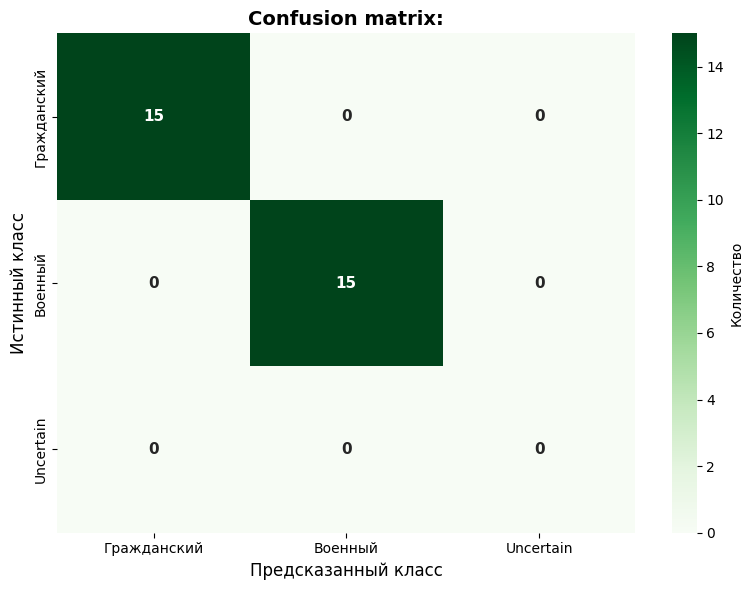

In [107]:
true_labels = [r["true_label"] for r in results]
clip_preds_raw = [r["clip"]["predicted"] for r in results]

clip_stats = count_response_types(clip_preds_raw)
clip_preds_for_metrics = [process_predictions_for_metrics(p, t) for p, t in zip(clip_preds_raw, true_labels)]
clip_metrics = calculate_metrics(true_labels, clip_preds_for_metrics)

print(f"CLIP (uncertain = неверный ответ):")
print(f'''Accuracy: {clip_metrics[0]}
Precision: {clip_metrics[1]}
Recall: {clip_metrics[2]}
F1-Score: {clip_metrics[3]}\n\n''')

print(f"Статистика ответов")
print(f'''Military: {clip_stats['military_percent']}% 
Civilian: {clip_stats['civilian_percent']}% 
Uncertain: {clip_stats['uncertain_percent']}%''')

print_confusion_matrix(true_labels, clip_preds_raw)

In [ ]:
### BLIP

BLIP (uncertain = неверный ответ):
Accuracy: 0.5
Precision: 0.5
Recall: 1.0
F1-Score: 0.6666666666666666


Статистика ответов
Military: 83.33333333333334% 
Civilian: 0.0% 
Uncertain: 16.666666666666664%


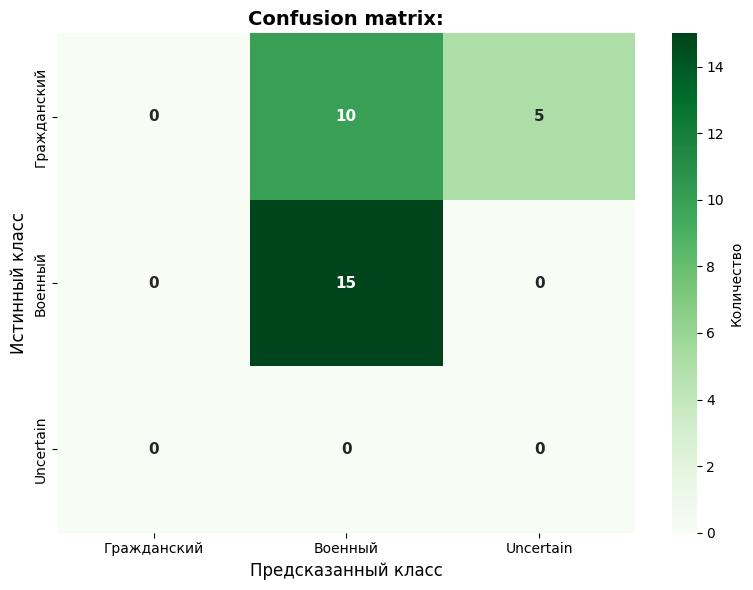

In [108]:
true_labels = [r["true_label"] for r in results]
blip_preds_raw = [r["blip"]["predicted"] for r in results]

blip_stats = count_response_types(blip_preds_raw)
blip_preds_for_metrics = [process_predictions_for_metrics(p, t) for p, t in zip(blip_preds_raw, true_labels)]
blip_metrics = calculate_metrics(true_labels, blip_preds_for_metrics)

print(f"BLIP (uncertain = неверный ответ):")
print(f'''Accuracy: {blip_metrics[0]}
Precision: {blip_metrics[1]}
Recall: {blip_metrics[2]}
F1-Score: {blip_metrics[3]}\n\n''')

print(f"Статистика ответов")
print(f'''Military: {blip_stats['military_percent']}% 
Civilian: {blip_stats['civilian_percent']}% 
Uncertain: {blip_stats['uncertain_percent']}%''')

print_confusion_matrix(true_labels, blip_preds_raw)

In [ ]:
### BLIP + QWEN Small

BLIP (uncertain = неверный ответ):
Accuracy: 0.2
Precision: 0.2631578947368421
Recall: 0.3333333333333333
F1-Score: 0.29411764705882354


Статистика ответов
Military: 16.666666666666664% 
Civilian: 3.3333333333333335% 
Uncertain: 80.0%


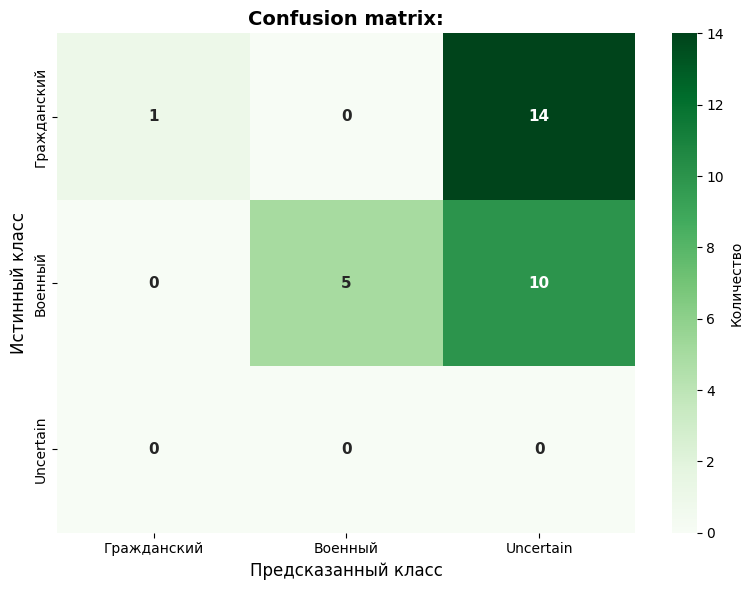

In [109]:
true_labels = [r["true_label"] for r in results]
small_preds_raw = [r["blip_qwen_small"]["predicted"] for r in results]

small_stats = count_response_types(small_preds_raw)
small_preds_for_metrics = [process_predictions_for_metrics(p, t) for p, t in zip(small_preds_raw, true_labels)]
small_metrics = calculate_metrics(true_labels, small_preds_for_metrics)

print(f"BLIP (uncertain = неверный ответ):")
print(f'''Accuracy: {small_metrics[0]}
Precision: {small_metrics[1]}
Recall: {small_metrics[2]}
F1-Score: {small_metrics[3]}\n\n''')

print(f"Статистика ответов")
print(f'''Military: {small_stats['military_percent']}% 
Civilian: {small_stats['civilian_percent']}% 
Uncertain: {small_stats['uncertain_percent']}%''')

print_confusion_matrix(true_labels, small_preds_raw)

### BLIP + Qwen medium

BLIP (uncertain = неверный ответ):
Accuracy: 0.2
Precision: 0.2631578947368421
Recall: 0.3333333333333333
F1-Score: 0.29411764705882354


Статистика ответов
Military: 16.666666666666664% 
Civilian: 6.666666666666667% 
Uncertain: 76.66666666666667%


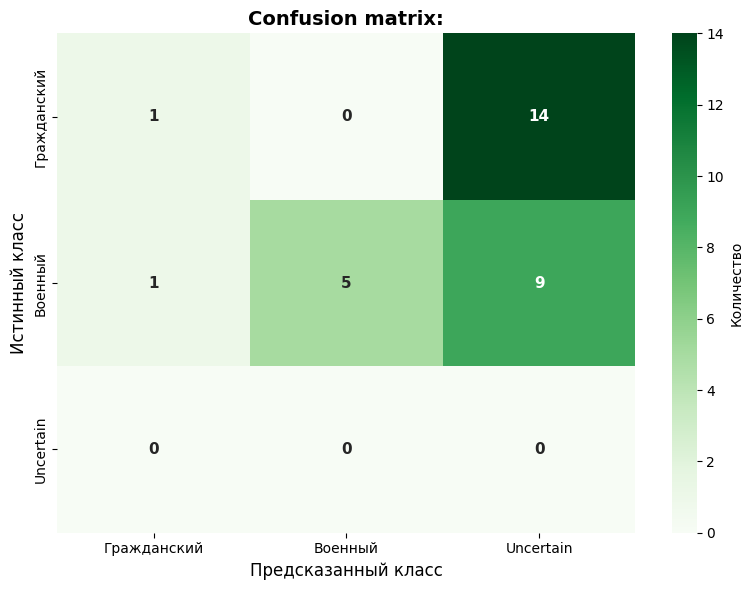

In [110]:
true_labels = [r["true_label"] for r in results]
medium_preds_raw = [r["blip_qwen_medium"]["predicted"] for r in results]

medium_stats = count_response_types(medium_preds_raw)
medium_preds_for_metrics = [process_predictions_for_metrics(p, t) for p, t in zip(medium_preds_raw, true_labels)]
medium_metrics = calculate_metrics(true_labels, medium_preds_for_metrics)

print(f"BLIP (uncertain = неверный ответ):")
print(f'''Accuracy: {medium_metrics[0]}
Precision: {medium_metrics[1]}
Recall: {medium_metrics[2]}
F1-Score: {medium_metrics[3]}\n\n''')

print(f"Статистика ответов")
print(f'''Military: {medium_stats['military_percent']}% 
Civilian: {medium_stats['civilian_percent']}% 
Uncertain: {medium_stats['uncertain_percent']}%''')

print_confusion_matrix(true_labels, medium_preds_raw)

## Выводы

1) CLIP хорошо справляется с классификацией изображений, при этом может быть развернут локально, что делает его очень хорошим инструментом обработки изображений.

2) BLIP используемый локально плохо справился как с классификацией изображений, так и с их описанием. При классификации явно наблюдается перекос в сторону военных самолетов. Описания же получаются очень сухими и неинформативными. С полученными описаниями LLM смогла точно определить только 6 картинок из 30. Пример непонятных описаний BLIP:
- on the runway at the airport
- the plane is blue and white with the klm logo on the tail
- this is a plane taking off from the airport

Кажется, что модель не слишком сильно понимает изображение, что отражается в довольно сухих описаниях изображений.

3) Использование LLM для анализа изображений сомнительная идея. В своем классическом виде LLM не умеют работать с ними, поэтому приходится использовать другие модели, которые будут переводить изображение в текст. При этом качество классификации будет скорее всего зависеть не от качества LLM, а от качества image to text модели. Хорошая image to text модель скорее всего сама правильно определит класс объекта через описание, без помощи LLM. Пример удачных описаний BLIP:

- the fighter jet is in the air
- it appears to be a fighter jet
- this is a b - 52 bomber flying over the desert

Судя этим описаниям сама BLIP смогла классифицировать тип самолета.